## Tensorflow Probability - Tuning with the Milk Analysis of Masked Effects  
### Day 14/100 Days of TensorFlow Probability  

In my last notebook, I reproduced the Richard McElreath's analysis of masking variables using the Milk dataset (see [Chpt 5. Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)).

Qualitatively, my results matched McElreath's. Specifically, I was able to reproduce the relationship between energy content and brain mass. However, my analyses struggled quite a bit when adding the `neocortex.prec` feature to the models. In contrast, Paul-Christian Brukner was able to reproduce McElreath's results exactly in brms (see 
[BRMS - Masked relationship](https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/multivariate-linear-models.html#masked-relationship)).



I have some suspicions about why my results were subtly different:  

  - McElreath's Rethinking package and Brukner's brms both use Stan under the hood and Stan uses the NoUTurn sampler (NUTS). However, I used a Hamiltonian Monte Carlo sampler. Perhaps this was the difference?  
  - alternatively, perhaps I need to tune the step_size in my sampler to allow it is explore more?  
  
I am going to explore these here. I have no idea if any of this will work, but let's find out.  

### Setup  

The NoUTurn Sampler is a reasonably new addition to tensorflow probability. You will need to check that you have version 0.8.0. Run the cell below, and if it isn't 0.8.0, then run the `pip3 install` cell as well.

In [13]:
import tensorflow_probability as tfp

tfp.__version__

'0.8.0'

In [0]:
! pip3 install -q --upgrade tensorflow-probability==0.8.0

We'll load the packages we need, create the `reset_sess()` function, define our `hmc` sample, the `nuts` sampler and `run_chain()` function.

In [0]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """

    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

# global parameteres
NUM_POSTERIOR_SAMPLES = 5000
NUM_BURNIN_ITERATIONS = 2000
NUM_ADAPTATION = int(0.5 * NUM_BURNIN_ITERATIONS)


def construct_hmc(log_posterior, adaptation_steps = NUM_ADAPTATION):
  
  """
  Define a reaonsably "vanilla" HMC chain.
  
  Parameters
  ----------
    @log_posterior: function of the joint posterior distribution
    
  """  
  
  hmc = tfp.mcmc.SimpleStepSizeAdaptation(

      # The actual HMC is very simple to define
      tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn = log_posterior,    # Log Posterior goes here
          num_leapfrog_steps = 3,
          step_size = 1                          # constant step size
      ),
      num_adaptation_steps = adaptation_steps
  )
  
  return hmc

def construct_nuts(log_posterior, adaptation_steps = NUM_ADAPTATION, nparams = 3):
  
  """
  Define a "vanilla" NoUTurn sampler, for direct comparison with Stan.
  
  Documentation: 
  
  https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/NoUTurnSampler
  """
  
  nuts = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn = log_posterior,
                step_size=1.0
            ),
            bijector=[tfb.Identity()] * nparams
        ),
        target_accept_prob=.8,
        num_adaptation_steps=adaptation_steps,
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
              inner_results=pkr.inner_results._replace(step_size=new_step_size)
          ),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )
  
  return nuts
  
  
@tf.function
def run_chain(kernel, inits=[], iters = [NUM_POSTERIOR_SAMPLES, NUM_BURNIN_ITERATIONS]):
  
  """
  Extract samples from HMC chain
  
  Parameters
  ----------
    @hmc: a MonteCarlo chain (returned from construct_hmc())
    @initial_state: starting point for the chain
    @iters: list [length of chain, burnin iterations]
    
  Returns
  -------
    samples: list of posterior samples for each parameter estimated
    
  """
  
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results = iters[0],
      num_burnin_steps = iters[1],
      current_state = inits,
      kernel = kernel
  )
  
  
  
  return samples

# These are optimisations - they make a HUGE difference to the speed of sampling
# see: https://adamhaber.github.io/2019/10/21/Bayesian-golf-puttings,-NUTS,-and-optimizing-your-sampling-function-with-TensorFlow-Probability.html
run_chain_xla = tf.function(run_chain, autograph = False, experimental_compile = True)

### Milk Dataset  

We'll grab the Milk dataset from McElrath's GitHub repo:

In [16]:
milk_url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv"
milk = pd.read_csv(milk_url, sep=";")

milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Experiment 1: `kcal.per.g ~ neocrotex.perc`  

The HMC struggled with this analyses previously. I suspect this is because there is no significant effect, so no real signal. But in that case, I would have expected the chains to settle around the priors, not struggle so much.

I will run this in both the hmc and the nuts samplers and see if there are any differences. Here is the model:

$$
kcal.per.g \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta . neocrotexperc \\
\alpha \sim Normal(0, 100) \\
\beta \sim Normal(0, 1) \\
\sigma \sim Uniform(0, 1)
$$


**HMC Results**

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


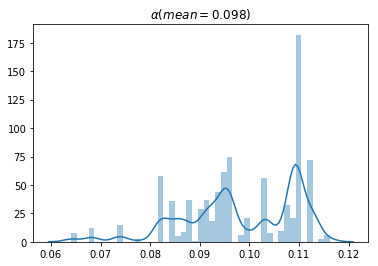

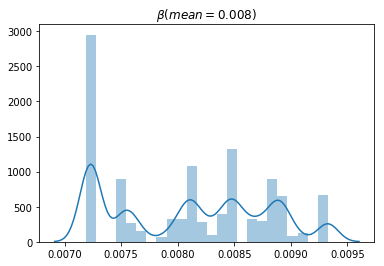

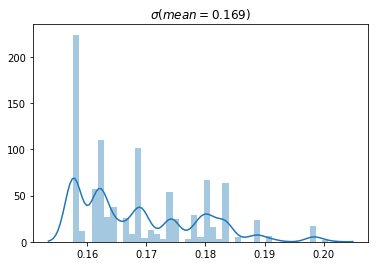

In [19]:
reset_sess()

def joint_log_prob(neocortex, calories, alpha, beta, sigma):
  """
  Model the relationship between energy content and percentage of the
  brain which is neocortex.
  """
  
  prior_alpha = tfd.Normal(0., 100.)
  prior_beta = tfd.Normal(0., 1.)
  prior_sigma = tfd.Uniform(0., 1.)
  
  mu = alpha + beta * neocortex
  rv_calories = tfd.Normal(loc = mu, scale = sigma)
  
  log_lik = (
      prior_alpha.log_prob(alpha) +
      prior_beta.log_prob(beta) +
      prior_sigma.log_prob(sigma) +
      tf.reduce_sum(rv_calories.log_prob(calories))
  )
  
  return log_lik

def unnormalised_posterior(alpha, beta, sigma):
  return joint_log_prob(neocortex, calories, alpha, beta, sigma)

# drop NA rows
milk.dropna(inplace = True)
  
# setup variables
# NOTE: the dtype declarations are necessary, otherwise it throws
#       a datatype error
[calories, neocortex] = [
    tf.convert_to_tensor(milk['kcal.per.g'].values, dtype=np.float32),
    tf.convert_to_tensor(milk['neocortex.perc'].values, dtype=np.float32)
]

# run our chain
[alpha_, beta_, sigma_] = run_chain(
    construct_hmc(unnormalised_posterior, adaptation_steps = 10000),
    inits = [0.1, 0.1, 0.1],
    iters = [30000, 20000]
)

sns.distplot(alpha_, label = "posterior")
plt.title("$\\alpha (mean = {:.3f})$".format(np.mean(alpha_)))
plt.show()

sns.distplot(beta_, label = "posterior")
plt.title("$\\beta (mean = {:.3f})$".format(np.mean(beta_)))
plt.show()

sns.distplot(sigma_, label = "posterior")
plt.title("$\\sigma (mean = {:.3f})$".format(np.mean(sigma_)))
plt.show()

You can see how the "vanilla" HMC has really struggled here. However, it is interesting to note that the results are actually much, much better using tensorflow-probability version 0.8.0 than they are for version 0.7.0!!! This is interesting. 

These results are still multimodal, and look like they haven't really converged yet. I could run longer chains perhaps. I also need to dig into chain convergence diagnostics in future posts. 

But numerically, they are closer to McElreath's results than they were previously.  


**NUTS**  
Let's see if there is any difference using the NUTS sampler:

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


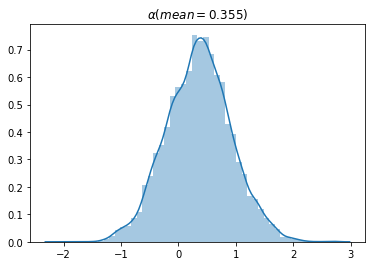

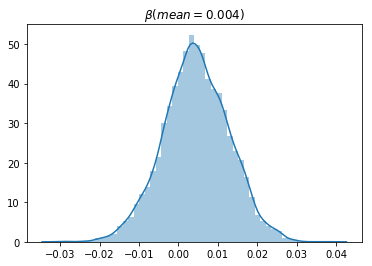

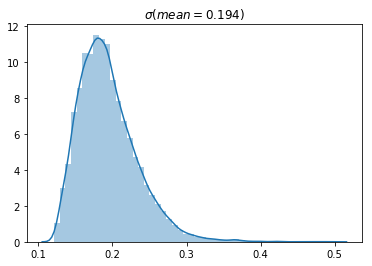

In [29]:
reset_sess()

# milk_scaled = milk.copy()
# for x in ['kcal.per.g', 'neocortex.perc']:
#   mu = np.mean(milk_scaled[x])
#   sigma = np.std(milk_scaled[x])
  
#   milk_scaled[x] = [(z - mu)/sigma for z in milk_scaled[x].values]
  
# setup variables
# NOTE: the dtype declarations are necessary, otherwise it throws
#       a datatype error
[calories, neocortex] = [
    tf.convert_to_tensor(milk['kcal.per.g'].values, dtype=np.float32),
    tf.convert_to_tensor(milk['neocortex.perc'].values, dtype=np.float32)
]

# run our chain
[alpha_, beta_, sigma_] = run_chain_xla(
    construct_nuts(unnormalised_posterior, adaptation_steps = 5000),
    inits = [0.01]*3,
    iters = [20000, 10000]
)

sns.distplot(alpha_, label = "posterior")
plt.title("$\\alpha (mean = {:.3f})$".format(np.mean(alpha_)))
plt.show()

sns.distplot(beta_, label = "posterior")
plt.title("$\\beta (mean = {:.3f})$".format(np.mean(beta_)))
plt.show()

sns.distplot(sigma_, label = "posterior")
plt.title("$\\sigma (mean = {:.3f})$".format(np.mean(sigma_)))
plt.show()

Wow - there we go, our results now match McElreath's exactly. Nice, so let's whip through the next two versions of the milk model.

### Model 2 `kcal.per.g ~ mass`  

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


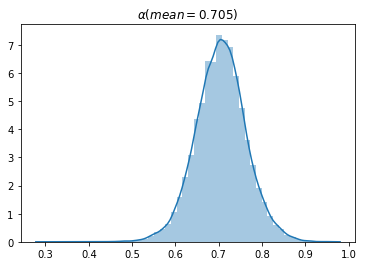

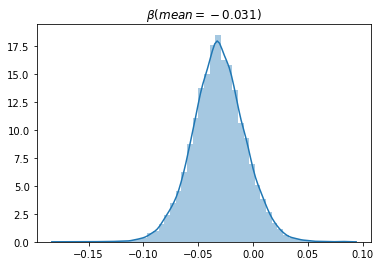

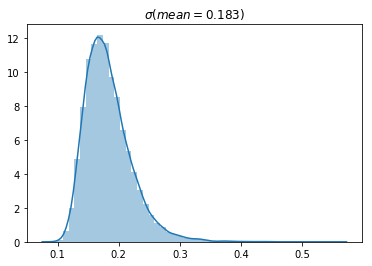

In [32]:
reset_sess()

def joint_log_prob(mass, calories, alpha, beta, sigma):
  """
  Model the relationship between energy content and percentage of the
  brain which is neocortex.
  """
  
  prior_alpha = tfd.Normal(0., 100.)
  prior_beta = tfd.Normal(0., 1.)
  prior_sigma = tfd.Uniform(0., 1.)
  
  mu = alpha + beta * mass
  rv_calories = tfd.Normal(loc = mu, scale = sigma)
  
  log_lik = (
      prior_alpha.log_prob(alpha) +
      prior_beta.log_prob(beta) +
      prior_sigma.log_prob(sigma) +
      tf.reduce_sum(rv_calories.log_prob(calories))
  )
  
  return log_lik

def unnormalised_posterior(alpha, beta, sigma):
  return joint_log_prob(mass, calories, alpha, beta, sigma)


# setup variables
# NOTE: the dtype declarations are necessary, otherwise it throws
#       a datatype error
[calories, mass] = [
    tf.convert_to_tensor(milk['kcal.per.g'].values, dtype=np.float32),
    tf.convert_to_tensor(np.log(milk['mass'].values), dtype=np.float32)
]

# run our chain
[alpha_, beta_, sigma_] = run_chain_xla(
    construct_nuts(unnormalised_posterior, adaptation_steps = 5000),
    inits = [1., 1., 0.1],
    iters = [20000, 10000]
)

sns.distplot(alpha_, label = "posterior")
plt.title("$\\alpha (mean = {:.3f})$".format(np.mean(alpha_)))
plt.show()

sns.distplot(beta_, label = "posterior")
plt.title("$\\beta (mean = {:.3f})$".format(np.mean(beta_)))
plt.show()

sns.distplot(sigma_, label = "posterior")
plt.title("$\\sigma (mean = {:.3f})$".format(np.mean(sigma_)))
plt.show()

Awesome - these are very, very similar to McElreath's. The speedup from the "xla" optimisations are incredible as well - will dig into this later this week.

### Model 3: `kcal.per.g ~ mass + neocortex.perc`  

Finally, McElreath explores what happens when both predictors are added to the model. Let's do the same:

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


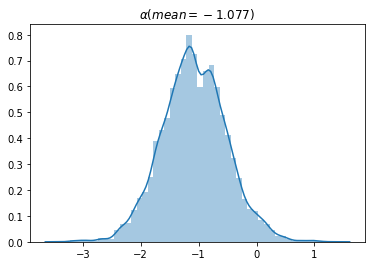

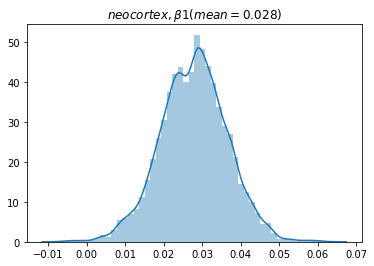

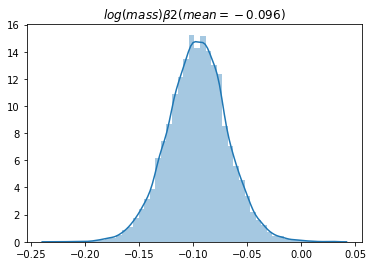

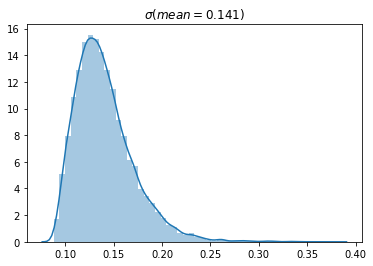

In [46]:
reset_sess()

def joint_log_prob(mass, neocortex, calories, alpha, beta1, beta2, sigma):
  """
  Model the relationship between energy content and percentage of the
  brain which is neocortex.
  """
  
  prior_alpha = tfd.Normal(0., 100.)
  prior_beta1 = tfd.Normal(0., 1.)
  prior_beta2 = tfd.Normal(0., 1.)
  prior_sigma = tfd.Uniform(0., 1.)
  
  mu = alpha + beta1 * neocortex + beta2 * mass
  rv_calories = tfd.Normal(loc = mu, scale = sigma)
  
  log_lik = (
      prior_alpha.log_prob(alpha) +
      prior_beta1.log_prob(beta1) +
      prior_beta2.log_prob(beta2) +
      prior_sigma.log_prob(sigma) +
      tf.reduce_sum(rv_calories.log_prob(calories))
  )
  
  return log_lik

def unnormalised_posterior(alpha, beta1, beta2, sigma):
  return joint_log_prob(mass, neocortex, calories, alpha, beta1, beta2, sigma)

# data prep
# Log and scale the mass
# milk_scaled['mass'] = [np.log(x) for x in milk.mass]
# mu, sigma = [np.mean(milk_scaled.mass), np.std(milk_scaled.mass)]
# milk_scaled['mass'] = [(x - mu) / sigma for x in milk_scaled.mass]

# setup variables
# NOTE: the dtype declarations are necessary, otherwise it throws
#       a datatype error
[mass, neocortex, calories] = [
    tf.convert_to_tensor(np.log(milk['mass'].values), dtype=np.float32),
    tf.convert_to_tensor(milk['neocortex.perc'].values, dtype=np.float32),
    tf.convert_to_tensor(milk['kcal.per.g'].values, dtype=np.float32)
]

# run our chain
[alpha_, beta1_, beta2_, sigma_] = run_chain_xla(
    construct_nuts(unnormalised_posterior, adaptation_steps = 5000, nparams=4),
    inits = [0.01, 0.01, 0.01, 0.5],
    iters = [20000, 10000]
)

sns.distplot(alpha_, label = "posterior")
plt.title("$\\alpha (mean = {:.3f})$".format(np.mean(alpha_)))
plt.show()

sns.distplot(beta1_, label = "posterior")
plt.title("$neocortex, \\beta1 (mean = {:.3f})$".format(np.mean(beta1_)))
plt.show()

sns.distplot(beta2_, label = "posterior")
plt.title("$log(mass) \\beta2 (mean = {:.3f})$".format(np.mean(beta2_)))
plt.show()

sns.distplot(sigma_, label = "posterior")
plt.title("$\\sigma (mean = {:.3f})$".format(np.mean(sigma_)))
plt.show()